In [19]:
import cv2
import Levenshtein
import optuna
import numpy as np
import pandas as pd
import plotly.express as px
import sklearn.metrics
import ipywidgets
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
%load_ext autoreload
%autoreload 2
from nncomp_molecule import constants

In [3]:
train_df = pd.read_pickle("/work/input/kfujikawa/bms-preprocess-v2/train.pkl").set_index("image_id")
train_df.head()

,InChI,image_path,InChI_length,w,h,w/h,w*h,is_flipped
image_id,,,,,,,,
4435736fd10b,InChI=1S/C65H110O6/c1-4-7-10-13-16-19-22-25-28...,/work/input/bms-molecular-translation/train/4/...,403,1472,788,1.868020,1159936,False
8c0e35ce3f1f,InChI=1S/C60H98O6/c1-4-7-10-13-16-19-22-25-27-...,/work/input/bms-molecular-translation/train/8/...,398,939,309,3.038835,290151,False
934593ad3cae,InChI=1S/C63H106O6/c1-4-7-10-13-16-19-22-25-27...,/work/input/bms-molecular-translation/train/9/...,397,826,661,1.249622,545986,False
c963808e309d,InChI=1S/C59H92O6/c1-4-7-10-13-16-19-22-25-28-...,/work/input/bms-molecular-translation/train/c/...,393,1268,883,1.436014,1119644,False
0aa425d5f5ac,InChI=1S/C62H106O6/c1-4-7-10-13-16-19-22-25-27...,/work/input/bms-molecular-translation/train/0/...,393,918,543,1.690608,498474,False


In [4]:
VALID_CSVs = [
    constants.OUTPUTDIR / "1106_swin_bert_384" / "valid_beam=1.csv",
    constants.OUTPUTDIR / "1106_swin_bert_384" / "valid_beam=4.csv",
    constants.OUTPUTDIR / "1109_vtnt_bert_512-1024-denoise-5" / "valid_beam=1.csv",
    constants.OUTPUTDIR / "1109_vtnt_bert_512-1024-denoise-5" / "valid_beam=4.csv",
]
valid_df = pd.concat([
    pd.read_csv(filename).assign(model=filename.parent.name)
    for filename in VALID_CSVs
], ignore_index=True)
valid_df["levenshtein"] = [
    Levenshtein.distance(x, y)
    for x, y in valid_df[["normed_InChI", "InChI_GT"]].values
]
display(valid_df.groupby("model").agg(**{
    "count": ("image_id", "count"),
    "levenshtein": ("levenshtein", "mean"),
    "is_valid": ("is_valid", "mean"),
    "score": ("score", "mean"),
    "normed_score": ("normed_score", "mean")
}))

,count,levenshtein,is_valid,score,normed_score
model,,,,,
1106_swin_bert_384,1212095,7.990907,0.569122,0.271816,0.071022
1109_vtnt_bert_512-1024-denoise-5,1212095,12.719371,0.600518,0.259066,0.068521


In [9]:
sort_keys = dict(
    image_id=True,
    is_valid=False,
    normed_score=True,
)
valid_ensembled_df = valid_df.sort_values(
    by=list(sort_keys.keys()),
    ascending=list(sort_keys.values()),
).groupby(["image_id", "model"]).first()
valid_ensembled_df.groupby("model").levenshtein.mean()

model
1106_swin_bert_384                   0.928129
1109_vtnt_bert_512-1024-denoise-5    0.922638
Name: levenshtein, dtype: float64

In [10]:
base_score = valid_ensembled_df.sort_values(
    by=list(sort_keys.keys()),
    ascending=list(sort_keys.values()),
).groupby("image_id").first().levenshtein.mean()
lower_score = valid_ensembled_df.groupby("image_id").levenshtein.min().mean()

print(f"Levenshtein: {base_score}")
print(f"Levenshtein (lower): {lower_score}")

Levenshtein: 0.8168955403660604
Levenshtein (lower): 0.6558603079791601


In [42]:
valid_ensembled_df["normed_InChI_length"] = valid_ensembled_df.normed_InChI.apply(len)
feature_df = valid_ensembled_df.reset_index().pivot_table(
    index=["image_id"],
    columns=["model"],
    values=["levenshtein", "is_valid", "normed_score", "normed_InChI", "normed_InChI_length"],
    aggfunc="first",
)
feature_df.head()

is_valid                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
000011a64c74               True                              True   
0000252b6d2b               True                              True   
000026fc6c36               True                              True   
000029a61c01               True                              True   
0000a5af84ef               True                              True   

                    levenshtein                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
000011a64c74                  0                                 0   
0000252b6d2b                  0                                 0   
000026fc6c36                  0                                 0   
000029a61c01                  0                                 0   
0000a5af84ef                  0                                 0   

                                                   normed_InChI  \
model                                        1106_swin_bert_384   
image_id                                                          
000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   
000029a61c01  InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12...   
0000a5af84ef  InChI=1S/C12H12O2S/c1-3-8-5-4-6-9-7-10(12(13)1...   

                                                                 \
model                         1109_vtnt_bert_512-1024-denoise-5   
image_id                                                          
000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   
000029a61c01  InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12...   
0000a5af84ef  InChI=1S/C12H12O2S/c1-3-8-5-4-6-9-7-10(12(13)1...   

             normed_InChI_length                                    \
model         1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                             
000011a64c74                  81                                81   
0000252b6d2b                 158                               158   
000026fc6c36                  96                                96   
000029a61c01                 103                               103   
0000a5af84ef                  75                                75   

                   normed_score                                    
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5  
image_id                                                           
000011a64c74       2.266927e-07                      4.846510e-07  
0000252b6d2b       2.920628e-06                      7.936634e-07  
000026fc6c36       5.120515e-06                      1.862741e-05  
000029a61c01       5.364418e-07                      6.573039e-07  
0000a5af84ef       2.363628e-07                      1.140553e-05

In [43]:
def func(x):
    return Levenshtein.distance(*x)

with mp.Pool() as pool:
    iter = pool.imap(func, feature_df.normed_InChI.values)
    feature_df["levenshtein_diff"] = list(tqdm(iter, total=len(feature_df)))

In [188]:
feature_df["levenshtein_diff_GT"] = np.diff(feature_df.levenshtein.values)
feature_df["normed_score_diff"] = np.diff(feature_df.normed_score.values)
feature_df["normed_InChI_length_diff"] = np.diff(feature_df.normed_InChI_length.values)
feature_df["use_swin"] = valid_ensembled_df.reset_index().sort_values(
    by=list(sort_keys.keys()),
    ascending=list(sort_keys.values()),
).groupby("image_id").first().values == "1106_swin_bert_384"
feature_df = feature_df.assign(**train_df)

with pd.option_context("display.max_columns", None):
    display(feature_df.head())

is_valid                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
000011a64c74               True                              True   
0000252b6d2b               True                              True   
000026fc6c36               True                              True   
000029a61c01               True                              True   
0000a5af84ef               True                              True   

                    levenshtein                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
000011a64c74                  0                                 0   
0000252b6d2b                  0                                 0   
000026fc6c36                  0                                 0   
000029a61c01                  0                                 0   
0000a5af84ef                  0                                 0   

                                                   normed_InChI  \
model                                        1106_swin_bert_384   
image_id                                                          
000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   
000029a61c01  InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12...   
0000a5af84ef  InChI=1S/C12H12O2S/c1-3-8-5-4-6-9-7-10(12(13)1...   

                                                                 \
model                         1109_vtnt_bert_512-1024-denoise-5   
image_id                                                          
000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   
000029a61c01  InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12...   
0000a5af84ef  InChI=1S/C12H12O2S/c1-3-8-5-4-6-9-7-10(12(13)1...   

             normed_InChI_length                                    \
model         1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                             
000011a64c74                  81                                81   
0000252b6d2b                 158                               158   
000026fc6c36                  96                                96   
000029a61c01                 103                               103   
0000a5af84ef                  75                                75   

                   normed_score                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
000011a64c74       2.266927e-07                      4.846510e-07   
0000252b6d2b       2.920628e-06                      7.936634e-07   
000026fc6c36       5.120515e-06                      1.862741e-05   
000029a61c01       5.364418e-07                      6.573039e-07   
0000a5af84ef       2.363628e-07                      1.140553e-05   

             levenshtein_diff levenshtein_diff_GT normed_score_diff  \
model                                                                 
image_id                                                              
000011a64c74                0                   0      2.579583e-07   
0000252b6d2b                0                   0     -2.126964e-06   
000026fc6c36                0                   0      1.350690e-05   
000029a61c01                0                   0      1.208621e-07   
0000a5af84ef                0                   0      1.116916e-05   

                                                          InChI  \
model                                                             
image_id                  

In [189]:
import lightgbm as lgb
from sklearn.model_selection import KFold

FEATURES = ["w", "h", "w*h", "w/h", "normed_InChI_length", "normed_score_diff", "normed_score", "levenshtein_diff", "is_valid", "use_swin"]
HYPERPARAMS = dict(
    random_state=0,
    learning_rate=0.01,
    boosting_type='gbdt',
    objective='binary',
    n_estimators=10000,
    importance_type='gain',
    eval_metric='binary',
)

kfold = KFold(n_splits=5)
dataset_df = feature_df[feature_df.levenshtein_diff > 0]
X, t = dataset_df[FEATURES], dataset_df.levenshtein_diff_GT > 0
X.columns = ['_'.join(col).strip("_") for col in X.columns.values]
oof_df = pd.DataFrame()
for train_idx, valid_idx in kfold.split(dataset_df):
    train_X, train_t = X.iloc[train_idx], t.iloc[train_idx]
    valid_X, valid_t = X.iloc[valid_idx], t.iloc[valid_idx]
    model = lgb.LGBMClassifier(**HYPERPARAMS)
    model.fit(
        train_X, train_t,
        eval_set=(valid_X, valid_t),
        early_stopping_rounds=500,
        verbose=500,
    )
    oof_df = oof_df.append(pd.DataFrame(dict(
        y=model.predict_proba(valid_X)[:, 1],
        t=valid_t
    )))

[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 500 rounds
[500]	valid_0's binary_logloss: 0.632916
[1000]	valid_0's binary_logloss: 0.634175
Early stopping, best iteration is:
[509]	valid_0's binary_logloss: 0.632848
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 500 rounds
[500]	valid_0's binary_logloss: 0.627091
[1000]	valid_0's binary_logloss: 0.627811
Early stopping, best iteration is:
[714]	valid_0's binary_logloss: 0.626944
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 500 rounds
[500]	valid_0's binary_logloss: 0.636246
Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.634986
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 500 rounds
[500]	valid_0's binary_logloss: 0.623273
Early stopping, best iteration is:
[415]	valid_0's binary_logloss: 0

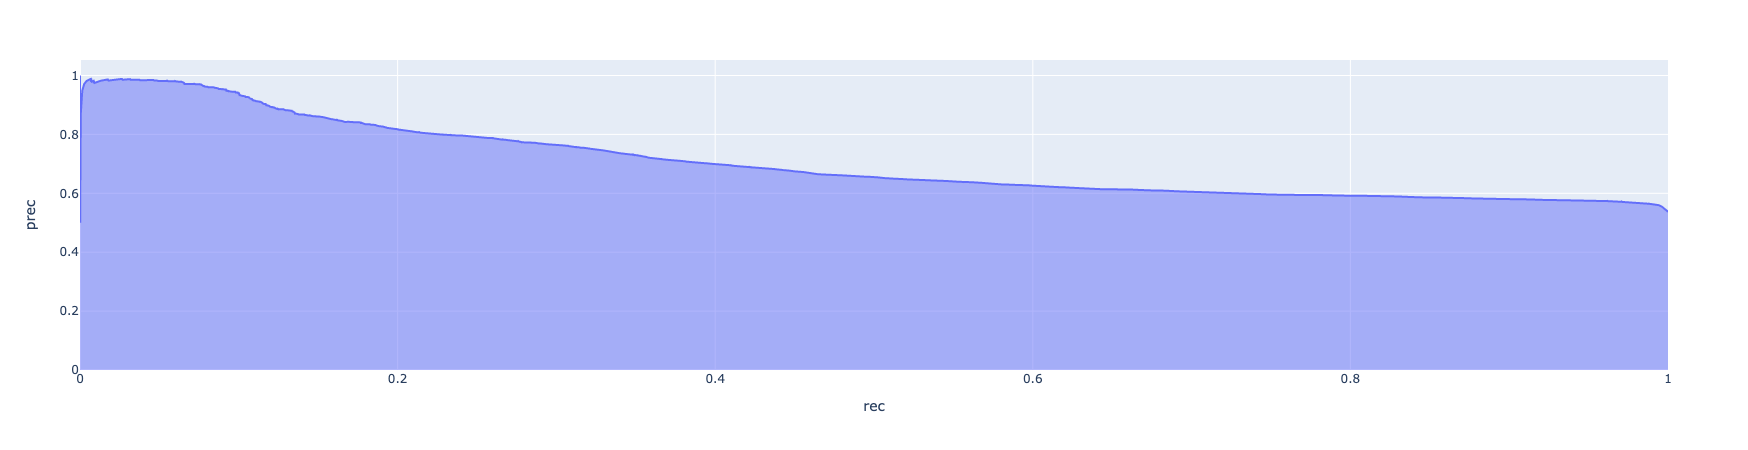

In [190]:
prec, rec, thresh = sklearn.metrics.precision_recall_curve(~oof_df.t, -oof_df.y)
auc_df = pd.DataFrame(dict(prec=prec, rec=rec, thresh=np.concatenate([[np.nan], thresh])))
px.area(auc_df, x="rec", y="prec", hover_data=["thresh"])

In [107]:
dataset_y_df = dataset_df.assign(**oof_df)
dataset_y_df["y>0.8"] = dataset_y_df.y > 0.8
dataset_y_df["y<0.2"] = dataset_y_df.y < 0.2
dataset_y_df[["y>0.8", "y<0.2"]].value_counts()

(y>0.8, )  (y<0.2, )
False      False        21019
           True          1367
True       False         1254
dtype: int64

In [191]:
np.where(
    dataset_y_df.normed_score_diff > 0,
    dataset_y_df.levenshtein["1106_swin_bert_384"],
    dataset_y_df.levenshtein["1109_vtnt_bert_512-1024-denoise-5"],
).mean()

4.75587986463621

In [193]:
np.where(
    dataset_y_df.y > 0.5,
    dataset_y_df.levenshtein["1106_swin_bert_384"],
    dataset_y_df.levenshtein["1109_vtnt_bert_512-1024-denoise-5"],
).mean()

4.414382402707276

In [152]:
(dataset_y_df.y > 0.5).rename("use_swin")

image_id
000388e433b8    False
000570c0475b    False
00082ad560fc    False
000978e2912f    False
000caa445277    False
                ...  
fff422ef782a    False
fff84481a782    False
fffa3f7d483e    False
fffcafaef5f7     True
fffec22defd3    False
Name: use_swin, Length: 23640, dtype: bool

In [186]:
feature_df["use_swin"] = valid_ensembled_df.reset_index().sort_values(
    by=list(sort_keys.keys()),
    ascending=list(sort_keys.values()),
).groupby("image_id").first().values == "1106_swin_bert_384"

feature_df.loc[dataset_y_df[dataset_y_df["y>0.8"]].index, "use_swin"] = True
feature_df.loc[dataset_y_df[dataset_y_df["y<0.2"]].index, "use_swin"] = False

In [187]:
np.where(
    feature_df["use_swin"],
    feature_df.levenshtein["1106_swin_bert_384"],
    feature_df.levenshtein["1109_vtnt_bert_512-1024-denoise-5"],
).mean()

0.8168955403660604

In [167]:
feature_df.loc[dataset_y_df.index, "use_swin"] = (dataset_y_df.y > 0.5).values

In [164]:
dataset_y_df.y > 0.5

image_id
000388e433b8    False
000570c0475b    False
00082ad560fc    False
000978e2912f    False
000caa445277    False
                ...  
fff422ef782a    False
fff84481a782    False
fffa3f7d483e    False
fffcafaef5f7     True
fffec22defd3    False
Name: y, Length: 23640, dtype: bool

is_valid                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
0022b07e7874               True                             False   
0023ef6e8498               True                             False   
004739c66fac               True                             False   
00e1af0f0b7c               True                             False   
00fd3cf595c7               True                              True   
...                         ...                               ...   
ff185534565a               True                             False   
ff364842296f               True                             False   
ff4b10a9c649               True                             False   
ff54d7dfae74               True                             False   
ff7274a289ed               True                             False   

                    levenshtein                                    \
model        1106_swin_bert_384 1109_vtnt_bert_512-1024-denoise-5   
image_id                                                            
0022b07e7874                  0                                 8   
0023ef6e8498                  0                                33   
004739c66fac                  0                                30   
00e1af0f0b7c                 12                                 4   
00fd3cf595c7                 32                                 0   
...                         ...                               ...   
ff185534565a                  0                                 8   
ff364842296f                  7                                 8   
ff4b10a9c649                  1                                23   
ff54d7dfae74                  0                                20   
ff7274a289ed                  0                                29   

                                                   normed_InChI  ...  \
model                                        1106_swin_bert_384  ...   
image_id                                                         ...   
0022b07e7874  InChI=1S/C26H30O5/c1-17-24(26(31-4)22-11-6-5-1...  ...   
0023ef6e8498  InChI=1S/C42H32BrN3/c43-41-23-13-14-24-42(41)4...  ...   
004739c66fac  InChI=1S/C22H30N2O2/c1-17(16-26-22(25)24-18(2)...  ...   
00e1af0f0b7c  InChI=1S/C17H12O/c1-2-9-17-15(6-1)13-8-7-11-4-...  ...   
00fd3cf595c7  InChI=1S/C13H26ClNO2S/c1-11-8-12(13(2,3)4)10-1...  ...   
...                                                         ...  ...   
ff185534565a  InChI=1S/C44H35N3/c1-27-23-34-25-32-22-21-31(2...  ...   
ff364842296f  InChI=1S/C22H34O2/c1-21-10-8-16(23)12-15(21)3-...  ...   
ff4b10a9c649  InChI=1S/C10H13ClO2/c1-5(2)8-6-3-4-7(13-6)9(11...  ...   
ff54d7dfae74  InChI=1S/C9H10O2/c10-8-4-1-2-5(9(8)11)7-3-6(4)...  ...   
ff7274a289ed  InChI=1S/C25H25ClN6O3/c1-16-23(29-35-28-16)25(...  ...   

             is_flipped         y      t y>0.8  y<0.2  
model                                                  
image_id                                               
0022b07e7874      False  0.961659   True  True  False  
0023ef6e8498      False  0.863447   True  True  False  
004739c66fac      False  0.832838   True  True  False  
00e1af0f0b7c      False  0.919813  False  True  False  
00fd3cf595c7      False  0.834463  False  True  False  
...                 ...       ...    ...   ...    ...  
ff185534565a      False  0.943099   True  True  False  
ff364842296f      False  0.864501   True  True  False  
ff4b10a9c649      False  0.888408   True  True  False  
ff54d7dfae74      False  0.866800   True  True  False  
ff7274a289ed      False  0.892127   True  True  False  

[1254 rows x 25 columns]